In [1]:
%matplotlib inline
import random, sys, os, pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy.testing as npt
from natsort import natsorted
from sklearn.model_selection import train_test_split
import tensorflow as tf
print("tensorflow version : ", tf.__version__)
import keras
from keras.models import load_model
from keras.layers import Input
from keras import optimizers
#from keras.metrics import MeanIoU

tensorflow version :  2.3.1


In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
    from google.colab import drive
    from tensorflow.python.client import device_lib

    google_drive = '/content/drive'
    drive.mount(google_drive)

    root_dir = google_drive + "/MyDrive/cs-433-project-2-team-afm"
    sys.path.append(root_dir)
    
    # Make sure that the graphics card appears in the device list
    # If this is not the case in google colab, then change the runtime type to GPU    
    npt.assert_('GPU' in str(device_lib.list_local_devices()))
else:
    root_dir = "."

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.image_utils import load_images, img_float_to_uint8, concatenate_images, make_img_overlay, predict
from src.utils.mask_to_submission import mask_to_submission_strings, masks_to_submission_enum
from src.utils.preprocessing import normalize_data, normalize_data_with_given_mean_and_std, data_augmentation, crop_center
from src.utils.neural_network import convolutional_model
from src.utils.plot_utils import plot_results

In [5]:
train_model = True #when equal to false, reload previously saved model
normalize = False

# Set environment

In [7]:
#Set seeds
SEED = 1
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
tf.keras.backend.set_floatx('float32')

## Load images

In [9]:
train_dir = root_dir + '/data/training/'

train_files, imgs = load_images(train_dir + "images/")
gt_files, gt_imgs = load_images(train_dir + "groundtruth/")
_, unlabel_imgs = load_images(root_dir + '/data/test_set_images/')

# Ensure that train and mask files have the same names
npt.assert_equal(natsorted(train_files), natsorted(gt_files))

Loading 100 images
Loading 100 images
Loading 50 images


In [10]:
TRAIN_SAMPLES = len(imgs)
IMAGE_HEIGHT = imgs[0].shape[0]
IMAGE_WIDTH = imgs[0].shape[1]
NUM_CHANNELS = imgs[0].shape[2]

print('Images length = ' + str(TRAIN_SAMPLES) + ', masks lengths: ' + str(len(gt_imgs)))
print('Image size = ' + str(IMAGE_HEIGHT) + ',' + str(IMAGE_WIDTH) + ',' + str(NUM_CHANNELS) )
print('GT shape size = ' + str(len(gt_imgs[0].shape) ))

Images length = 100, masks lengths: 100
Image size = 400,400,3
GT shape size = 2


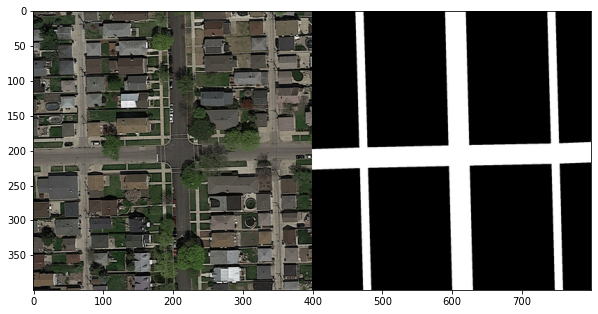

In [11]:
# Show first image and its groundtruth image
for i in range(0,1):
  cimg = concatenate_images(imgs[i], gt_imgs[i])
  fig1 = plt.figure(figsize=(10, 10))
  plt.imshow(cimg, cmap='Greys_r');

In [12]:
imgs = np.array(imgs)
gt_imgs = np.reshape(np.array(gt_imgs), (TRAIN_SAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH, 1));
unlabel_imgs = np.array(unlabel_imgs)
print(imgs.shape)
print(gt_imgs.shape)
print(unlabel_imgs.shape)

(100, 400, 400, 3)
(100, 400, 400, 1)
(50, 608, 608, 3)


## Do train/test split

In [13]:
train_images, test_images, train_masks, test_masks = train_test_split(imgs, gt_imgs, test_size=0.2, random_state=SEED)

print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(80, 400, 400, 3)
(80, 400, 400, 1)
TEST SET
(20, 400, 400, 3)
(20, 400, 400, 1)


## Normalize

In [14]:

if normalize ==  True:
  # Normalize data
  norm_train_images, _, std_data  = normalize_data(train_images, mean_zero = True)
  norm_test_images = normalize_data_with_given_mean_and_std(test_images, 0, std_data)
  norm_unlabel_images = normalize_data_with_given_mean_and_std(unlabel_imgs, 0, std_data)
else:
  norm_train_images = train_images
  norm_test_images = test_images
  norm_unlabel_images = unlabel_imgs

## Input augmentation

In [15]:
CROPPED_WIDTH = 320 # multiple of 2^6

In [16]:
# Provide the same seed
image_generator = data_augmentation(norm_train_images, seed=SEED, crop_length_=CROPPED_WIDTH)
mask_generator = data_augmentation(train_masks, seed=SEED, crop_length_=CROPPED_WIDTH)

In [17]:
# Also crop the test images and masks
cropped_test_images = np.zeros((norm_test_images.shape[0], CROPPED_WIDTH, CROPPED_WIDTH, norm_test_images.shape[3]))
cropped_test_masks = np.zeros((test_masks.shape[0], CROPPED_WIDTH, CROPPED_WIDTH, test_masks.shape[3]))
for i in range(cropped_test_images.shape[0]):
    cropped_test_images[i] = crop_center(norm_test_images[i], (CROPPED_WIDTH, CROPPED_WIDTH))
    cropped_test_masks[i] = crop_center(test_masks[i], (CROPPED_WIDTH, CROPPED_WIDTH))
norm_test_images = cropped_test_images
test_masks = cropped_test_masks

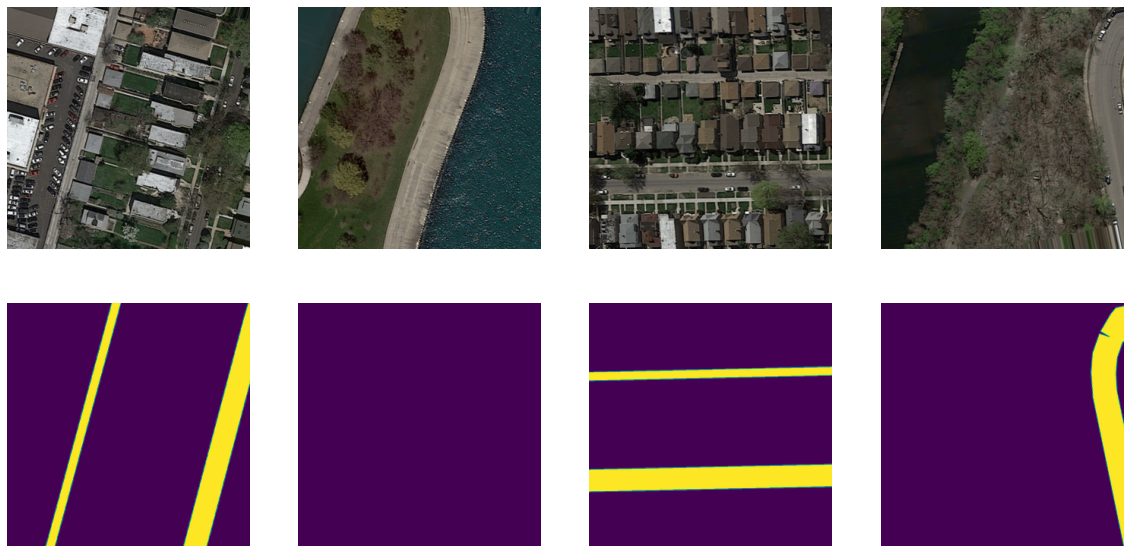

In [18]:
# generate samples and plot
rows = 1 
ncols = 4
fig, ax = plt.subplots(nrows=2*rows, ncols=ncols, figsize=(20,10))

for r in range(0,rows):
    batch_image = next(image_generator)
    batch_mask = next(mask_generator)
    for i in range(0,ncols):
      image_train = batch_image[i];
      image_mask = np.squeeze(batch_mask[i]);
  
      # plot image
      row_im = 2*r;
      row_mask = row_im + 1;
      ax[row_im,i].imshow(image_train);
      ax[row_im,i].axis('off');
      ax[row_mask,i].imshow(image_mask);
      ax[row_mask,i].axis('off');

# U-net for predictions

## Run the experimental setup

In [19]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [20]:
configurations = [
                  {'num_skips': 3, 'dropout_input': 0, 'dropout_hidden': 0, 'filters_first': 16},
                  {'num_skips': 4, 'dropout_input': 0, 'dropout_hidden': 0, 'filters_first': 16},
                  {'num_skips': 6, 'dropout_input': 0, 'dropout_hidden': 0, 'filters_first': 8},
                  
                  {'num_skips': 3, 'dropout_input': 0.1, 'dropout_hidden': 0.15, 'filters_first': 16},
                  {'num_skips': 4, 'dropout_input': 0.1, 'dropout_hidden': 0.15, 'filters_first': 16},
                  {'num_skips': 6, 'dropout_input': 0.1, 'dropout_hidden': 0.15, 'filters_first': 8},
                  
                  {'num_skips': 3, 'dropout_input': 0.1, 'dropout_hidden': 0.3, 'filters_first': 16},
                  {'num_skips': 4, 'dropout_input': 0.1, 'dropout_hidden': 0.3, 'filters_first': 16},
                  {'num_skips': 6, 'dropout_input': 0.1, 'dropout_hidden': 0.3, 'filters_first': 8},
                 ]

In [ ]:
for config in configurations:
    inputs = Input((CROPPED_WIDTH, CROPPED_WIDTH, NUM_CHANNELS))
    model = convolutional_model(inputs, skip_connections = config['num_skips'], input_dropout=config['dropout_input'], hidden_dropout=config['dropout_hidden'], filters_first=config['filters_first'], normalize_input=False)
    model.summary()
            
    opt = keras.optimizers.Adam(LEARNING_RATE)
    bce = tf.keras.losses.BinaryCrossentropy()
    model.compile(
      optimizer=opt,
      loss=bce,
      metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    model_name = "model_" + str(config['num_skips']) + "_" + str(config['dropout_input']) + "_" + str(config['dropout_hidden']) + '_' + str(config['filters_first'])
    result_dir = root_dir + "/results/" + model_name + "/"

    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    model_name_ext = model_name + ".h5"
    
    checkpoint = keras.callbacks.ModelCheckpoint(result_dir + model_name + "_{epoch:03d}.ckpt", save_weights_only=True, verbose=1, save_freq=300) 

    if train_model == True:
        history = model.fit(zip(image_generator, mask_generator),
                    epochs=EPOCHS,
                    steps_per_epoch=100,
                    validation_data=(norm_test_images, test_masks),
                    batch_size = BATCH_SIZE
                    , callbacks=[checkpoint]
                    )
        model.save(result_dir + model_name_ext)
        pickle.dump(history.history, open(result_dir + model_name + "_history.p", "wb"))

## Create setup for the final model

In [21]:
train_images, test_images, train_masks, test_masks = train_test_split(imgs, gt_imgs, test_size=0.01, random_state=SEED)

print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(99, 400, 400, 3)
(99, 400, 400, 1)
TEST SET
(1, 400, 400, 3)
(1, 400, 400, 1)


In [22]:
norm_train_images = train_images
norm_test_images = test_images
norm_unlabel_images = unlabel_imgs

In [23]:
image_generator = data_augmentation(norm_train_images, seed=SEED, crop_length_=CROPPED_WIDTH)
mask_generator = data_augmentation(train_masks, seed=SEED, crop_length_=CROPPED_WIDTH)

In [24]:
cropped_test_images = np.zeros((norm_test_images.shape[0], CROPPED_WIDTH, CROPPED_WIDTH, norm_test_images.shape[3]))
cropped_test_masks = np.zeros((test_masks.shape[0], CROPPED_WIDTH, CROPPED_WIDTH, test_masks.shape[3]))
for i in range(cropped_test_images.shape[0]):
    cropped_test_images[i] = crop_center(norm_test_images[i], (CROPPED_WIDTH, CROPPED_WIDTH))
    cropped_test_masks[i] = crop_center(test_masks[i], (CROPPED_WIDTH, CROPPED_WIDTH))
norm_test_images = cropped_test_images
test_masks = cropped_test_masks

In [25]:
inputs = Input((CROPPED_WIDTH, CROPPED_WIDTH, NUM_CHANNELS))
model = convolutional_model(inputs, skip_connections = 6, input_dropout = 0, hidden_dropout = 0, filters_first = 8, normalize_input=False)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 320, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 8)  224         dropout[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 8)  32          conv2d[0][0]                     
_______________________________________________________________________________________

In [26]:
EPOCHS = 150
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [27]:
opt = keras.optimizers.Adam(LEARNING_RATE)
bce = tf.keras.losses.BinaryCrossentropy()
model.compile(
      optimizer=opt,
      loss=bce,
      metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

## Train the final model

In [ ]:
model_name = "final_model"
result_dir = root_dir + "/results/" + model_name + "/"

if not os.path.exists(result_dir):
  os.makedirs(result_dir)

model_name_ext = model_name + ".h5"

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(result_dir + model_name + "_{epoch:03d}.ckpt", save_weights_only=True, verbose=1) 

if train_model == True:
    history = model.fit(zip(image_generator, mask_generator),
                    epochs=EPOCHS,
                    steps_per_epoch=100,
                    validation_data=(norm_test_images, test_masks),
                    batch_size = BATCH_SIZE
                    , callbacks=[checkpoint]
                    )

## Save model and history

In [ ]:
if train_model == True:
  model.save(result_dir + model_name_ext)
  pickle.dump(history.history, open(result_dir + model_name + "_history.p", "wb"))

## Load model

In [28]:
model = load_model('results/final/best-model/model_6_0_0_8_e150.h5')

## Evaluate model for test images

In [29]:
model.evaluate(norm_test_images, test_masks)

1/1 [==============================] - 0s 3ms/step - loss: 0.2851 - precision: 0.9403 - recall: 0.7917


[0.28509238362312317, 0.9402796626091003, 0.7917271852493286]

In [30]:
predictions = model.predict(norm_test_images, verbose=1);

1/1 [==============================] - 0s 3ms/step


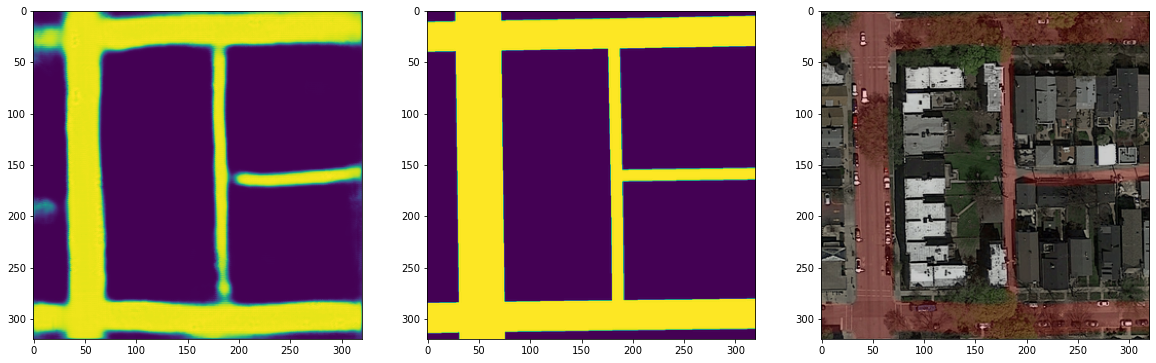

In [37]:
nrows=1
fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(20,20))

for index in range(0,nrows):
  ax[0].imshow(np.squeeze(predictions[index]))
  ax[1].imshow(np.squeeze(test_masks[index]))
  new_img = make_img_overlay(norm_test_images[index], np.squeeze(predictions[index]))
  ax[2].imshow(new_img);

## Do predictions for the unlabeled data

In [ ]:
predictions = []
for test_image in unlabel_imgs:
    predictions.append(predict(test_image, model, CROPPED_WIDTH, CROPPED_WIDTH));
predictions = np.array(predictions)

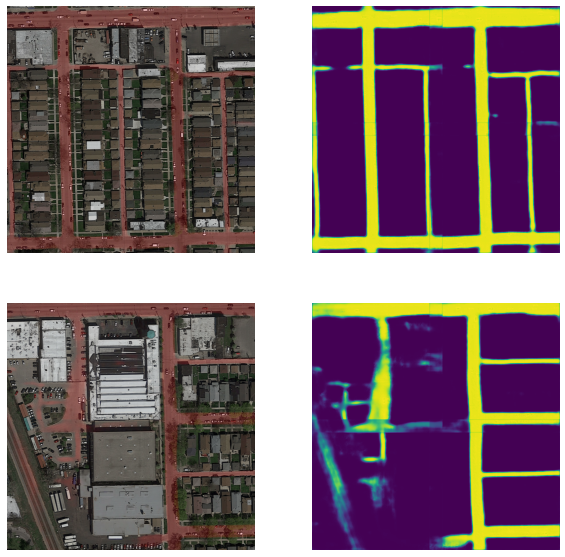

In [39]:
plot_results(nrows=2, originals=unlabel_imgs, predictions=predictions)

In [ ]:
submission_filename = 'results/final/best-model/model_6_0_0_8_e150' + '_submission.csv'
masks_to_submission_enum(submission_filename, *predictions)